In [17]:
import geopandas as gpd
import requests
from shapely.geometry import Point, LineString, MultiPoint, MultiLineString
from shapely.ops import linemerge, split
import numpy as np

import json
from shapely.geometry import mapping

In [2]:
filepath = "../data/second_Testdata_Arosa.gpx"

In [16]:
def to_3d_linestring_profile(line2d: LineString,
                             crs: int = 2056,
                             nb_points: int = 42,
                             offset: int | None = None,
                             distinct_points: bool = True,
                             which: str = "COMB"):
    """
    Erzeugt einen 3D-LineString, indem es die Swisstopo-Profile-API in einem
    einzigen Request nutzt (§ Profile API).
    """

    nb_points = len(line2d.coords)
    # 1) GeoJSON aus der Shapely-Geometry erstellen
    geom_geojson = mapping(line2d)

    # 2) Parameter für den Request
    url = "https://api3.geo.admin.ch/rest/services/profile.json"
    params: dict[str, str] = {
        "geom": json.dumps(geom_geojson),
        "sr": str(crs),
        "nb_points": str(nb_points),
        "distinct_points": str(distinct_points).lower(),
    }
    if offset is not None:
        params["offset"] = str(offset)

    # 3) GET-Request an die Profile-API
    r = requests.get(url, params=params, timeout=10)
    r.raise_for_status()

    # 4) JSON-Antwort parsen: Liste von Objekten mit
    #    { "dist":…, "alts": { … }, "easting":…, "northing":… }
    profile = r.json()

    # 5) 3D-Koordinaten extrahieren (hier COMB-Höhe)
    coords3d = [
        (pt["easting"], pt["northing"], pt["alts"][which])
        for pt in profile
    ]

    return LineString(coords3d)

In [3]:
def get_height(easting: float, 
               northing: float, 
               max_retries: int = 3):
    """
    Fragt die Höhe für einen Punkt (in LV95) bei der Swisstopo-API ab
    und gibt sie als float zurück.
    """
    HEIGHT_URL = "https://api3.geo.admin.ch/rest/services/height"
    params = {"easting": easting, "northing": northing}
    for attempt in range(max_retries):
        r = requests.get(HEIGHT_URL, params=params, timeout=5)
        if r.status_code == 200:
            return r.json()["height"]
    r.raise_for_status()


In [4]:
def to_3d_Point(pt: Point):
    z = get_height(pt.x, pt.y)
    return Point(pt.x, pt.y, z) 

In [5]:
def densify(linestring: LineString, 
            interval: float = 100.0):
    
    total_len = linestring.length
    orig_dists = [linestring.project(Point(x, y)) for x, y in linestring.coords]
    regular_dists = list(np.arange(0, total_len, interval))
    regular_dists.append(total_len)
    all_dists = sorted(set(orig_dists + regular_dists))
    pts = [linestring.interpolate(d) for d in all_dists]

    return LineString([(p.x, p.y) for p in pts])

In [6]:
def to_3d_linestring(line2d: LineString):

    coords2d = list(line2d.coords)
    coords3d = []
    for x, y in coords2d:
        z = get_height(x, y)
        coords3d.append((x, y, z))

    return LineString(coords3d)

In [7]:

## Erstellung Waypoints GeoDataFrame
gdf_waypoints = gpd.read_file(filepath, layer="waypoints", driver="GPX")
gdf_waypoints['id'] = range(1, len(gdf_waypoints)+1)
gdf_waypoints = gdf_waypoints.set_crs(epsg=4326, allow_override=True).to_crs(epsg=2056)
gdf_waypoints["geometry"] = gdf_waypoints.geometry.apply(to_3d_Point)
gdf_waypoints = gdf_waypoints[["id","name", "geometry"]]

## Erstellung des MultiLine Tracks GeoDataFrame
gdf_routes = gpd.read_file(filepath, layer="routes", driver="GPX")
gdf_routes = gdf_routes.set_crs(epsg=4326, allow_override=True).to_crs(epsg=2056)
gdf_routes = gdf_routes[["geometry"]]
mls = MultiLineString(gdf_routes.geometry.tolist())
merged  = linemerge(mls)


## Aufteilen der Linie in Segmente gemäss den Waypoints
points = gdf_waypoints.geometry.to_list()
projected = [merged.interpolate(merged.project(pt)) for pt in points]
mp = MultiPoint(projected)
pieces = split(merged, mp)
segments = list(pieces.geoms)
gdf_lines = gpd.GeoDataFrame(
    {'geometry': segments}
)
gdf_lines['id'] = range(1, len(gdf_lines)+1)

## Weitere Stützpunkte den Linestrings hinzufügen
gdf_lines['geometry'] = gdf_lines.geometry.apply(lambda ln: densify(ln, interval=100.0))

## Umdimensionierung der Segmente GeoDataFrame
gdf_lines = gdf_lines[["id", "geometry"]]

# ## Erstellung 3D-LineStrings
# gdf_lines_3d = gdf_lines.copy()
# gdf_lines_3d["geometry"] = [to_3d_linestring(line) for line in gdf_lines.geometry]


In [8]:
gdf_waypoints

,id,name,geometry
0,1,Start - Arosa Isel,POINT Z (2771363.006 1182944.671 1619.8)
1,2,Talboden,POINT Z (2771631.169 1182149.947 1642.7)
2,3,Wasserfall,POINT Z (2771672.973 1181859.38 1660.2)
3,4,Sattel Alteiner,POINT Z (2772048.846 1181239.261 1952.8)
4,5,Altein,POINT Z (2772884.396 1180425.213 2271.4)
5,6,Schiesshornbode,POINT Z (2773192.438 1181617.741 2428.5)
6,7,Obersäss Sattel,POINT Z (2773796.352 1182123.088 2315.5)
7,8,Talboden,POINT Z (2772192.138 1182893.917 1664)
8,9,Ende Arosa Isel,POINT Z (2771346.967 1182942.088 1620)


In [9]:
gdf_lines

,id,geometry
0,1,"LINESTRING (2771363.006 1182944.671, 2771384.2..."
1,2,"LINESTRING (2771631.169 1182149.947, 2771623.0..."
2,3,"LINESTRING (2771672.973 1181859.38, 2771708.40..."
3,4,"LINESTRING (2772048.846 1181239.261, 2772084.3..."
4,5,"LINESTRING (2772884.396 1180425.213, 2772880.2..."
5,6,"LINESTRING (2773192.438 1181617.741, 2773244.5..."
6,7,"LINESTRING (2773796.352 1182123.088, 2773807.1..."
7,8,"LINESTRING (2772192.138 1182893.917, 2772142.3..."


In [10]:
gdf_lines_3d = gdf_lines.copy()
gdf_lines_3d["geometry"] = [to_3d_linestring(line) for line in gdf_lines.geometry]

In [11]:
gdf_lines_3d

,id,geometry
0,1,"LINESTRING Z (2771363.006 1182944.671 1619.8, ..."
1,2,"LINESTRING Z (2771631.169 1182149.947 1642.7, ..."
2,3,"LINESTRING Z (2771672.973 1181859.38 1660.2, 2..."
3,4,"LINESTRING Z (2772048.846 1181239.261 1952.8, ..."
4,5,"LINESTRING Z (2772884.396 1180425.213 2271.4, ..."
5,6,"LINESTRING Z (2773192.438 1181617.741 2428.5, ..."
6,7,"LINESTRING Z (2773796.352 1182123.088 2315.5, ..."
7,8,"LINESTRING Z (2772192.138 1182893.917 1664, 27..."


In [21]:
gdf_lines = gdf_lines.copy()

gdf_lines_3d["length_m"] = gdf_lines_3d.geometry.length
gdf_lines_3d["wkt_length"] = gdf_lines_3d.geometry.apply(lambda geom: len(geom.wkt))

gdf_lines_3d

,id,geometry,length_m,wkt_length
0,1,"LINESTRING Z (2771363.006 1182944.671 1619.8, ...",878.454958,999
1,2,"LINESTRING Z (2771631.169 1182149.947 1642.7, ...",323.576270,594
2,3,"LINESTRING Z (2771672.973 1181859.38 1660.2, 2...",1466.104433,2320
3,4,"LINESTRING Z (2772048.846 1181239.261 1952.8, ...",1567.294669,2670
4,5,"LINESTRING Z (2772884.396 1180425.213 2271.4, ...",1521.754011,2028
5,6,"LINESTRING Z (2773192.438 1181617.741 2428.5, ...",951.902648,1181
6,7,"LINESTRING Z (2773796.352 1182123.088 2315.5, ...",2853.694194,4822
7,8,"LINESTRING Z (2772192.138 1182893.917 1664, 27...",1066.285269,1364


In [18]:
gdf_lines_v2 = gdf_lines.copy()

gdf_lines_3d_v2 = gdf_lines_v2.copy()
gdf_lines_3d_v2["geometry"] = gdf_lines_v2.geometry.apply(
    lambda ln: to_3d_linestring_profile(ln)
)

HTTPError: 400 Client Error: Bad Request for url: https://api3.geo.admin.ch/rest/services/profile.json?geom=%7B%22type%22%3A+%22LineString%22%2C+%22coordinates%22%3A+%5B%5B2773796.3515946334%2C+1182123.0882057052%5D%2C+%5B2773807.195880802%2C+1182128.2494628062%5D%2C+%5B2773826.6845268235%2C+1182121.4662200408%5D%2C+%5B2773877.7363060573%2C+1182151.5668597515%5D%2C+%5B2773876.582224074%2C+1182159.5739049802%5D%2C+%5B2773874.5588094164%2C+1182173.6123987022%5D%2C+%5B2773868.415649252%2C+1182193.538174298%5D%2C+%5B2773855.2072751652%2C+1182257.1464530323%5D%2C+%5B2773854.8583302596%2C+1182258.8268858162%5D%2C+%5B2773806.984047636%2C+1182295.922744649%5D%2C+%5B2773786.494340774%2C+1182327.5916105388%5D%2C+%5B2773785.588903626%2C+1182328.9910530888%5D%2C+%5B2773728.605797329%2C+1182337.4701065521%5D%2C+%5B2773746.3997784695%2C+1182357.6078584741%5D%2C+%5B2773734.758383337%2C+1182365.1107757296%5D%2C+%5B2773733.901625042%2C+1182365.662959254%5D%2C+%5B2773732.630626382%2C+1182386.6486165216%5D%2C+%5B2773743.222281824%2C+1182395.1276699654%5D%2C+%5B2773725.4283006685%2C+1182417.5971615978%5D%2C+%5B2773695.277901877%2C+1182436.7644834875%5D%2C+%5B2773653.405043627%2C+1182463.3840502158%5D%2C+%5B2773626.265124304%2C+1182505.8314195648%5D%2C+%5B2773624.8075739094%2C+1182508.111057143%5D%2C+%5B2773631.586233389%2C+1182523.585329673%5D%2C+%5B2773611.6739211436%2C+1182550.718300702%5D%2C+%5B2773593.6681068772%2C+1182579.7590587523%5D%2C+%5B2773583.53259224%2C+1182587.20224787%5D%2C+%5B2773567.400801367%2C+1182599.0489053472%5D%2C+%5B2773525.0341795785%2C+1182624.4860656888%5D%2C+%5B2773519.4654566064%2C+1182654.5437290801%5D%2C+%5B2773518.0436869725%2C+1182662.2178535236%5D%2C+%5B2773506.3928659805%2C+1182667.941214596%5D%2C+%5B2773499.8260396104%2C+1182652.4669420652%5D%2C+%5B2773451.951756995%2C+1182662.429829876%5D%2C+%5B2773447.715094814%2C+1182673.6645756874%5D%2C+%5B2773446.2258193567%2C+1182673.8221385854%5D%2C+%5B2773399.628979092%2C+1182678.7520077738%5D%2C+%5B2773394.7568175816%2C+1182695.7101146623%5D%2C+%5B2773386.9189925496%2C+1182702.4933574207%5D%2C+%5B2773365.9475147664%2C+1182709.4885765163%5D%2C+%5B2773363.466804971%2C+1182711.2215637267%5D%2C+%5B2773354.720359992%2C+1182717.33170096%5D%2C+%5B2773328.0293882727%2C+1182712.6682215733%5D%2C+%5B2773329.5122200297%2C+1182727.7185414333%5D%2C+%5B2773319.979730121%2C+1182751.2479147462%5D%2C+%5B2773299.4111356526%2C+1182758.241968673%5D%2C+%5B2773298.160919902%2C+1182758.6670865095%5D%2C+%5B2773235.549157007%2C+1182834.9390181315%5D%2C+%5B2773217.827237042%2C+1182856.5273747798%5D%2C+%5B2773200.6924519744%2C+1182832.8653835615%5D%2C+%5B2773174.46901353%2C+1182866.760226791%5D%2C+%5B2773151.344270936%2C+1182896.6498816737%5D%2C+%5B2773136.2656600713%2C+1182887.7337690424%5D%2C+%5B2773109.8780910466%2C+1182913.7962521405%5D%2C+%5B2773109.0938159553%2C+1182921.3589219984%5D%2C+%5B2773106.108438318%2C+1182950.146557507%5D%2C+%5B2773081.091652097%2C+1182982.0388065658%5D%2C+%5B2773059.159127194%2C+1183001.2427414851%5D%2C+%5B2773057.88130102%2C+1183001.744505976%5D%2C+%5B2773032.0861667716%2C+1183011.873491175%5D%2C+%5B2773018.3783387034%2C+1183033.4779179583%5D%2C+%5B2772998.8446837175%2C+1183032.792063145%5D%2C+%5B2772978.6256373283%2C+1183034.8496276%5D%2C+%5B2772973.121764979%2C+1183030.801878018%5D%2C+%5B2772950.18189411%2C+1183013.9310556534%5D%2C+%5B2772885.086922846%2C+1182984.2936103647%5D%2C+%5B2772809.333960812%2C+1182949.8036301997%5D%2C+%5B2772804.103911593%2C+1182965.7319336464%5D%2C+%5B2772801.451959669%2C+1182973.8085488381%5D%2C+%5B2772777.463260558%2C+1182990.2690644888%5D%2C+%5B2772772.3228250314%2C+1183001.5856689932%5D%2C+%5B2772763.4127367907%2C+1183006.043725311%5D%2C+%5B2772748.8746360056%2C+1183043.3227970966%5D%2C+%5B2772746.963343104%2C+1183048.223796638%5D%2C+%5B2772763.0700410632%2C+1183083.2023923642%5D%2C+%5B2772748.3775532558%2C+1183100.7885322825%5D%2C+%5B2772717.6267539477%2C+1183110.9206414914%5D%2C+%5B2772717.0433689095%2C+1183111.6547884177%5D%2C+%5B2772692.8761105957%2C+1183142.0674957081%5D%2C+%5B2772650.8750188686%2C+1183127.0569635716%5D%2C+%5B2772635.566035911%2C+1183133.3488328427%5D%2C+%5B2772629.8744729995%2C+1183135.6880195728%5D%2C+%5B2772591.998488501%2C+1183104.916428674%5D%2C+%5B2772575.498059613%2C+1183085.0274735768%5D%2C+%5B2772559.372640468%2C+1183078.6479974191%5D%2C+%5B2772557.5324220043%2C+1183078.932587109%5D%2C+%5B2772518.121568229%2C+1183085.0274736024%5D%2C+%5B2772464.495174326%2C+1183068.5158882511%5D%2C+%5B2772461.2290052962%2C+1183066.1897457838%5D%2C+%5B2772422.8690923518%2C+1183038.8700872674%5D%2C+%5B2772425.119150848%2C+1183007.723233051%5D%2C+%5B2772423.9284750475%2C+1182986.0779973818%5D%2C+%5B2772422.8690923764%2C+1182966.8195329353%5D%2C+%5B2772387.993185847%2C+1182969.0711127673%5D%2C+%5B2772351.992250071%2C+1182985.9579614548%5D%2C+%5B2772348.142682299%2C+1182990.5591652128%5D%2C+%5B2772338.491899152%2C+1183002.0942835216%5D%2C+%5B2772327.2416067333%2C+1182973.199009132%5D%2C+%5B2772292.3657001965%2C+1182999.467440407%5D%2C+%5B2772291.3140858584%2C+1182989.231184521%5D%2C+%5B2772288.2405929863%2C+1182959.314266909%5D%2C+%5B2772230.864101597%2C+1182975.0753256811%5D%2C+%5B2772236.8725904413%2C+1182966.557544566%5D%2C+%5B2772275.8652713313%2C+1182911.2805640274%5D%2C+%5B2772250.739618242%2C+1182910.5300374296%5D%2C+%5B2772243.796047629%2C+1182908.5616003869%5D%2C+%5B2772192.1375597767%2C+1182893.916904346%5D%5D%7D&sr=2056&nb_points=107&distinct_points=true

In [13]:
def combine_waypoints_lines(gdf_lines: gpd.GeoDataFrame,
                            gdf_waypoints: gpd.GeoDataFrame):

    ## Lines GeoDataFrame unbennene und angleichen an Waypoints GeoDataFrame
    gdf = (
        gdf_lines
        .rename(columns={"id": "segment_id"})
        .copy()
        .set_geometry("geometry")
        .rename_geometry("segment_geom")
        .to_crs(gdf_waypoints.crs)
    )

    ## Start und endpunkt extrahieren
    gdf["von_pkt_geom"] = gdf.segment_geom.apply(lambda ln: Point(*ln.coords[0]))
    gdf["bis_pkt_geom"] = gdf.segment_geom.apply(lambda ln: Point(*ln.coords[-1]))

    ## Erstellung der GeoDataFrames der Start und Endpunkte der Linien
    gdf_v = gdf[["segment_id", "von_pkt_geom"]].set_geometry("von_pkt_geom")
    gdf_b = gdf[["segment_id", "bis_pkt_geom"]].set_geometry("bis_pkt_geom")
    gdf_v.crs = gdf.crs
    gdf_b.crs = gdf.crs

    ## Joins erstellen
    sj_v = (
        gpd.sjoin_nearest(
            gdf_v,
            gdf_waypoints[["id", "name", "geometry"]],
            how="left"
        )
        .rename(columns={"id": "von_pkt_id", "name": "von_pkt_name"})
        .drop(columns=["index_right"])
    )

    sj_b = (
        gpd.sjoin_nearest(
            gdf_b,
            gdf_waypoints[["id", "name", "geometry"]],
            how="left"
        )
        .rename(columns={"id": "bis_pkt_id", "name": "bis_pkt_name"})
        .drop(columns=["index_right"])
    )

    ## Merge der Waypoints in die Linien GeoDataFrame
    df = (
        gdf
        .merge(sj_v[["segment_id", "von_pkt_name"]], on="segment_id", how="left")
        .merge(sj_b[["segment_id", "bis_pkt_name"]], on="segment_id", how="left")
    )

    ## Resultat-GeoDataFrame
    out = df[[
        "segment_id",
        "von_pkt_name", "von_pkt_geom",
        "bis_pkt_name", "bis_pkt_geom",
        "segment_geom"
    ]]

    out["segment_id"]     = out["segment_id"].astype("Int32")
    out["von_pkt_name"]   = out["von_pkt_name"].astype(str)
    out["bis_pkt_name"]   = out["bis_pkt_name"].astype(str)

    return gpd.GeoDataFrame(out, geometry="segment_geom", crs=gdf.crs)


In [15]:
gdf_waypoints = gdf_waypoints.set_crs(epsg=2056, allow_override=True)
gdf_lines_3d = gdf_lines_3d.set_crs(epsg=2056, allow_override=True)

In [28]:
res = combine_waypoints_lines(gdf_lines_3d, gdf_waypoints)

In [34]:
res

,segment_id,von_pkt_name,von_pkt_geom,bis_pkt_name,bis_pkt_geom,segment_geom
0,1,Startpunkt,POINT Z (2615292.286 1264887.924 279.7),Hintere Burg,POINT Z (2616488.117 1263427.786 431.5),"LINESTRING Z (2615292.286 1264887.924 279.7, 2..."
1,2,Hintere Burg,POINT Z (2616488.117 1263427.786 431.5),Mittlere Burg,POINT Z (2616298.894 1263194.66 476.4),"LINESTRING Z (2616488.117 1263427.786 431.5, 2..."
2,3,Mittlere Burg,POINT Z (2616298.894 1263194.66 476.4),Lecker Weinchen,POINT Z (2617072.551 1262557.063 411),"LINESTRING Z (2616298.894 1263194.66 476.4, 26..."
3,4,Lecker Weinchen,POINT Z (2617072.551 1262557.063 411),Schauenburg,POINT Z (2618037.624 1261126.735 568.2),"LINESTRING Z (2617072.551 1262557.063 411, 261..."
4,5,Schauenburg,POINT Z (2618037.624 1261126.735 568.2),Ende,POINT Z (2621085.137 1261293.638 310.5),"LINESTRING Z (2618037.624 1261126.735 568.2, 2..."


In [36]:
res2 = res.copy()

res2 = res2.sort_values("von_pkt_name")

res2.reset_index()

,index,segment_id,von_pkt_name,von_pkt_geom,bis_pkt_name,bis_pkt_geom,segment_geom
0,1,2,Hintere Burg,POINT Z (2616488.117 1263427.786 431.5),Mittlere Burg,POINT Z (2616298.894 1263194.66 476.4),"LINESTRING Z (2616488.117 1263427.786 431.5, 2..."
1,3,4,Lecker Weinchen,POINT Z (2617072.551 1262557.063 411),Schauenburg,POINT Z (2618037.624 1261126.735 568.2),"LINESTRING Z (2617072.551 1262557.063 411, 261..."
2,2,3,Mittlere Burg,POINT Z (2616298.894 1263194.66 476.4),Lecker Weinchen,POINT Z (2617072.551 1262557.063 411),"LINESTRING Z (2616298.894 1263194.66 476.4, 26..."
3,4,5,Schauenburg,POINT Z (2618037.624 1261126.735 568.2),Ende,POINT Z (2621085.137 1261293.638 310.5),"LINESTRING Z (2618037.624 1261126.735 568.2, 2..."
4,0,1,Startpunkt,POINT Z (2615292.286 1264887.924 279.7),Hintere Burg,POINT Z (2616488.117 1263427.786 431.5),"LINESTRING Z (2615292.286 1264887.924 279.7, 2..."


In [37]:

# 1. Start- und Endknoten ermitteln
all_vons = set(res2['von_pkt_name'])
all_bis  = set(res2['bis_pkt_name'])
start = (all_vons - all_bis).pop()
end   = (all_bis  - all_vons).pop()

# 2. Lookup: von_name → Zeilenindex
von_index = {row.von_pkt_name: idx for idx, row in res2.iterrows()}

# 3. In Topologie-Reihenfolge laufen
ordered_idx = []
current = start
while current in von_index:
    idx = von_index[current]
    ordered_idx.append(idx)
    current = res2.at[idx, 'bis_pkt_name']
# wenn current==end, ist current nicht mehr in von_index und loop endet

# 4. Neu sortieren und segment_id neu vergeben
gdf_sorted = res2.loc[ordered_idx].reset_index(drop=True)
gdf_sorted['segment_id'] = gdf_sorted.index + 1
gdf_sorted = gdf_sorted.set_geometry('segment_geom')


# Ergebnis
gdf_sorted

,segment_id,von_pkt_name,von_pkt_geom,bis_pkt_name,bis_pkt_geom,segment_geom
0,1,Startpunkt,POINT Z (2615292.286 1264887.924 279.7),Hintere Burg,POINT Z (2616488.117 1263427.786 431.5),"LINESTRING Z (2615292.286 1264887.924 279.7, 2..."
1,2,Hintere Burg,POINT Z (2616488.117 1263427.786 431.5),Mittlere Burg,POINT Z (2616298.894 1263194.66 476.4),"LINESTRING Z (2616488.117 1263427.786 431.5, 2..."
2,3,Mittlere Burg,POINT Z (2616298.894 1263194.66 476.4),Lecker Weinchen,POINT Z (2617072.551 1262557.063 411),"LINESTRING Z (2616298.894 1263194.66 476.4, 26..."
3,4,Lecker Weinchen,POINT Z (2617072.551 1262557.063 411),Schauenburg,POINT Z (2618037.624 1261126.735 568.2),"LINESTRING Z (2617072.551 1262557.063 411, 261..."
4,5,Schauenburg,POINT Z (2618037.624 1261126.735 568.2),Ende,POINT Z (2621085.137 1261293.638 310.5),"LINESTRING Z (2618037.624 1261126.735 568.2, 2..."


<Axes: >

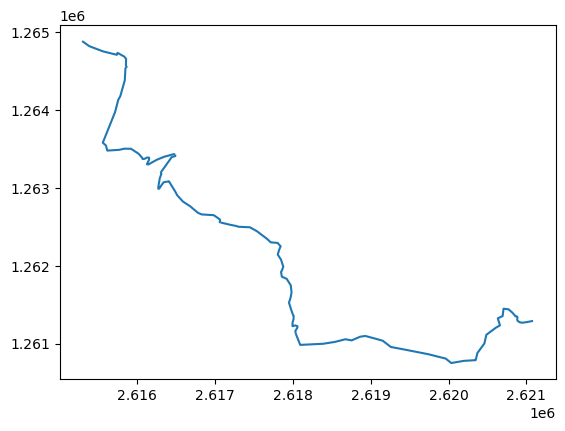

In [11]:
gdf_lines_3d.plot()

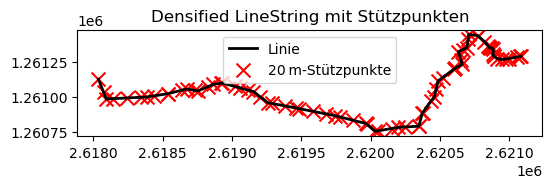

In [12]:
import matplotlib.pyplot as plt

# 1) Deinen (bereits densified) LineString holen
dense_line0 = gdf_lines.geometry.iloc[4]

# 2) Koordinaten extrahieren
# Variante a: mit coords
coords = list(dense_line0.coords)     # [(x1,y1), (x2,y2), ...]
x_pts, y_pts = zip(*coords)

# Variante b: mit .xy
# x_pts, y_pts = dense_line0.xy

# 3) Plotten
fig, ax = plt.subplots(figsize=(6,8))
#    erst die Linie
x_line, y_line = dense_line0.xy
ax.plot(x_line, y_line, '-', lw=2, color='black', label='Linie')
#    dann die Punkte
ax.scatter(x_pts, y_pts, s=100, c='red', marker='x', label='20 m-Stützpunkte')

ax.set_aspect('equal')
ax.set_title("Densified LineString mit Stützpunkten")
ax.legend()
plt.show()


## Andere API

In [12]:
import json
from shapely.geometry import mapping

In [ ]:
def to_3d_linestring_profile(line2d: LineString,
                             crs: int = 2056,
                             nb_points: int = 42,
                             offset: int | None = None,
                             distinct_points: bool = True,
                             which: str = "COMB"):
    """
    Erzeugt einen 3D-LineString, indem es die Swisstopo-Profile-API in einem
    einzigen Request nutzt (§ Profile API).
    """

    nb_points = len(line2d.coords)
    # 1) GeoJSON aus der Shapely-Geometry erstellen
    geom_geojson = mapping(line2d)

    # 2) Parameter für den Request
    url = "https://api3.geo.admin.ch/rest/services/profile.json"
    params: dict[str, str] = {
        "geom": json.dumps(geom_geojson),
        "sr": str(crs),
        "nb_points": str(nb_points),
        "distinct_points": str(distinct_points).lower(),
    }
    if offset is not None:
        params["offset"] = str(offset)

    # 3) GET-Request an die Profile-API
    r = requests.get(url, params=params, timeout=10)
    r.raise_for_status()

    # 4) JSON-Antwort parsen: Liste von Objekten mit
    #    { "dist":…, "alts": { … }, "easting":…, "northing":… }
    profile = r.json()

    # 5) 3D-Koordinaten extrahieren (hier COMB-Höhe)
    coords3d = [
        (pt["easting"], pt["northing"], pt["alts"][which])
        for pt in profile
    ]

    return LineString(coords3d)

In [ ]:

## Erstellung Waypoints GeoDataFrame
gdf_waypoints_v2 = gpd.read_file(filepath, layer="waypoints", driver="GPX")
gdf_waypoints_v2['id'] = range(1, len(gdf_waypoints_v2)+1)
gdf_waypoints_v2 = gdf_waypoints_v2.set_crs(epsg=4326, allow_override=True).to_crs(epsg=2056)
gdf_waypoints_v2["geometry"] = gdf_waypoints_v2.geometry.apply(to_3d_Point)
gdf_waypoints_v2 = gdf_waypoints_v2[["id","name", "geometry"]]

## Erstellung des MultiLine Tracks GeoDataFrame
gdf_routes_v2 = gpd.read_file(filepath, layer="routes", driver="GPX")
gdf_routes_v2 = gdf_routes_v2.set_crs(epsg=4326, allow_override=True).to_crs(epsg=2056)
gdf_routes_v2 = gdf_routes_v2[["geometry"]]
mls_v2 = MultiLineString(gdf_routes_v2.geometry.tolist())
merged_v2  = linemerge(mls_v2)


## Aufteilen der Linie in Segmente gemäss den Waypoints
points_v2 = gdf_waypoints_v2.geometry.to_list()
projected_v2 = [merged_v2.interpolate(merged_v2.project(pt)) for pt in points_v2]
mp_v2 = MultiPoint(projected_v2)
pieces_v2 = split(merged_v2, mp_v2)
segments_v2 = list(pieces_v2.geoms)
gdf_lines_v2 = gpd.GeoDataFrame(
    {'geometry': segments_v2}
)
gdf_lines_v2['id'] = range(1, len(gdf_lines_v2)+1)

## Weitere Stützpunkte den Linestrings hinzufügen
gdf_lines_v2['geometry'] = gdf_lines_v2.geometry.apply(lambda ln: densify(ln, interval=100.0))

## Umdimensionierung der Segmente GeoDataFrame
gdf_lines_v2 = gdf_lines_v2[["id", "geometry"]]

## Erstellung 3D-LineStrings via Profile-API (nur 1 Request pro Segment)
gdf_lines_3d_v2 = gdf_lines_v2.copy()
gdf_lines_3d_v2["geometry"] = gdf_lines_v2.geometry.apply(
    lambda ln: to_3d_linestring_profile(ln)
)

In [55]:
len(gdf_lines_3d_v2.geometry.iloc[0].coords)

72

In [54]:
len(gdf_lines_3d.geometry.iloc[0].coords)

63

In [49]:
import numpy as np
from shapely.geometry import LineString

def linestrings_equal_3d(
    ls1: LineString,
    ls2: LineString,
    tol: float = 1e-6
) -> bool:
    """
    Vergleicht zwei 3D-LineStrings inkl. Z-Koordinate.
    Gibt True zurück, wenn sie dieselben Punktfolgen (innerhalb tol) haben.
    """
    coords1 = np.array(ls1.coords)  # Form: (n_points, 3)
    coords2 = np.array(ls2.coords)

    # 1) Gleich viele Punkte?
    if coords1.shape != coords2.shape:
        return False

    # 2) Punktweise Abstand prüfen
    return np.allclose(coords1, coords2, atol=tol)


In [50]:
from shapely.geometry import LineString

def geodf_linestrings_equal_3d(
    gdf1, 
    gdf2, 
    tol: float = 1e-6
) -> bool:
    """
    Vergleicht zwei GeoDataFrames Zeile für Zeile:
    Alle Geometrien müssen 3D-LineStrings sein
    und paarweise innerhalb der tol-Abweichung übereinstimmen.
    """
    # 1) gleiche Länge?
    if len(gdf1) != len(gdf2):
        return False

    # 2) Index-Reihenfolge sicherstellen (falls nötig)
    gdf2 = gdf2.reindex(gdf1.index)

    # 3) Punkt-für-Punkt-Vergleich
    for idx in gdf1.index:
        ls1 = gdf1.at[idx, "geometry"]
        ls2 = gdf2.at[idx, "geometry"]
        if not linestrings_equal_3d(ls1, ls2, tol=tol):
            print(f"Unterschied in Zeile {idx}")
            return False

    return True

In [51]:
if geodf_linestrings_equal_3d(gdf_lines_3d, gdf_lines_3d_v2):
    print("beide Varianten liefern dasselbe Ergebnis")
else:
    print("Unterschiede in den Z-Werten oder Punktfolgen!")

Unterschied in Zeile 0
Unterschiede in den Z-Werten oder Punktfolgen!


In [53]:
import pandas as pd

equal_mask = [
    linestrings_equal_3d(ls1, ls2, tol=1e-6)
    for ls1, ls2 in zip(gdf_lines_3d.geometry, gdf_lines_3d_v2.geometry)
]
# als Pandas-Serie:
equal_series = pd.Series(equal_mask, index=gdf_lines_3d.index)
print(equal_series.value_counts())     # wie viele True vs. False
print(equal_series[equal_series == False])  # die Indexe der Fehlermatches


False    4
True     1
Name: count, dtype: int64
0    False
1    False
2    False
3    False
dtype: bool
